# **Dataset**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score, precision_recall_curve, auc, precision_score, recall_score, f1_score, roc_curve
from imblearn.under_sampling import RandomUnderSampler
from sklearn import preprocessing

from sklearn import svm
from sklearn import ensemble
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

from imblearn.under_sampling import RandomUnderSampler

In [2]:
dataset = pd.read_csv("creditcard.csv")
dataset.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
dataset.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [4]:
# separating the data for analysis
legit = dataset[dataset.Class == 0]
fraud = dataset[dataset.Class == 1]
print("Fraud ", fraud.shape)

Fraud  (492, 31)


In [5]:
# Assume 'Class' column contains the labels (fraud or not fraud)
X = np.asarray(dataset.drop(columns='Class', axis = 1))
y = np.asarray(dataset['Class'])

In [6]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.pipeline import Pipeline

# Define SMOTE-ENN pipeline
smote_enn_pipeline = Pipeline([
    ('smote', SMOTE(sampling_strategy='auto', random_state=42)),
    ('enn', EditedNearestNeighbours(sampling_strategy='auto'))
])

# Apply SMOTE-ENN for oversampling and cleaning
X_resampled, y_resampled = smote_enn_pipeline.fit_resample(X_train, y_train)

# Count the number of instances after resampling
legit_instances_resampled = sum(y_resampled == 0)
fraud_instances_resampled = sum(y_resampled == 1)
total_instances_resampled = len(y_resampled)

print(f"Number of Legitimate Instances after SMOTE-ENN: {legit_instances_resampled}")
print(f"Number of Fraudulent Instances after SMOTE-ENN: {fraud_instances_resampled}")
print(f"Total Number of Instances after SMOTE-ENN: {total_instances_resampled}")

Number of Legitimate Instances after SMOTE-ENN: 227451
Number of Fraudulent Instances after SMOTE-ENN: 218649
Total Number of Instances after SMOTE-ENN: 446100


In [9]:
from imblearn.combine import SMOTEENN

classifiers = {
    "LR": LogisticRegression(),
    "RF": RandomForestClassifier(),
    "XGBoost": XGBClassifier()
}

# Train and evaluate each classifier with SMOTE-ENN sampling
for name, clf in classifiers.items():
    # Apply SMOTE-ENN sampling
    smote_enn = SMOTEENN(random_state=42)
    X_resampled, y_resampled = smote_enn.fit_resample(X_train, y_train)

    # Train the classifier on the SMOTE-ENN-resampled data
    clf.fit(X_resampled, y_resampled)
    y_pred = clf.predict(X_test)

    # Check if the classifier supports probability estimation
    if hasattr(clf, "predict_proba"):
        y_prob = clf.predict_proba(X_test)[:, 1]  # Probability estimates for the positive class
        roc_auc = roc_auc_score(y_test, y_prob)
    else:
        roc_auc = None

    accuracy = accuracy_score(y_test, y_pred)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1_score = 2 * (precision * recall) / (precision + recall)
    fnr = fn / (fn + tp)
    fpr = fp / (fp + tn)

    print(f"\n{name} Classifier with SMOTE-ENN Sampling")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"F1-Score: {f1_score:.4f}")
    print(f"Recall: {recall:.4f}")

    if roc_auc is not None:
        print(f"ROC AUC: {roc_auc:.4f}")
    else:
        print("ROC AUC: Not available for this classifier.")

    print(f"FNR: {fnr:.4f}")
    print(f"FPR: {fpr:.4f}")


LR Classifier with SMOTE-ENN Sampling
Accuracy: 0.9675
Precision: 0.0452
F1-Score: 0.0860
Recall: 0.8878
ROC AUC: 0.9620
FNR: 0.1122
FPR: 0.0323

RF Classifier with SMOTE-ENN Sampling
Accuracy: 0.9995
Precision: 0.8542
F1-Score: 0.8454
Recall: 0.8367
ROC AUC: 0.9857
FNR: 0.1633
FPR: 0.0002

XGBoost Classifier with SMOTE-ENN Sampling
Accuracy: 0.9993
Precision: 0.7830
F1-Score: 0.8137
Recall: 0.8469
ROC AUC: 0.9847
FNR: 0.1531
FPR: 0.0004


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

classifiers = {"SVM": SVC(probability=True)}

# Subsample the dataset
X_train_sub, _, y_train_sub, _ = train_test_split(X_train, y_train, train_size=0.1, stratify=y_train, random_state=42)

# Train and evaluate each classifier with SMOTE-ENN hybrid sampling on the subsampled dataset
for name, clf in classifiers.items():
    # Apply SMOTE-ENN hybrid sampling
    smote_enn = SMOTEENN(random_state=42)
    X_resampled, y_resampled = smote_enn.fit_resample(X_train_sub, y_train_sub)

    # Train the classifier on the SMOTE-ENN-resampled data
    clf.fit(X_resampled, y_resampled)
    y_pred = clf.predict(X_test)

    # Check if the classifier supports probability estimation
    if hasattr(clf, "predict_proba"):
        y_prob = clf.predict_proba(X_test)[:, 1]  # Probability estimates for the positive class
        roc_auc = roc_auc_score(y_test, y_prob)
    else:
        roc_auc = None

    accuracy = accuracy_score(y_test, y_pred)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1_score = 2 * (precision * recall) / (precision + recall)
    fnr = fn / (fn + tp)  # False Negative Rate
    fpr = fp / (fp + tn)  # False Positive Rate

    print(f"\n{name} Classifier with SMOTE-ENN:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"F1-Score: {f1_score:.4f}")
    print(f"Recall: {recall:.4f}")

    if roc_auc is not None:
        print(f"ROC AUC: {roc_auc:.4f}")
    else:
        print("ROC AUC: Not available for this classifier.")

    print(f"FNR: {fnr:.4f}")
    print(f"FPR: {fpr:.4f}")


SVM Classifier with SMOTE-ENN:
Accuracy: 0.4634
Precision: 0.0014
F1-Score: 0.0028
Recall: 0.4388
ROC AUC: 0.4679
FNR: 0.5612
FPR: 0.5366


In [11]:
classifiers = {
    "Ada Boost": AdaBoostClassifier(),
    "SGD": SGDClassifier(),
    "MLP": MLPClassifier(),
    "DT": DecisionTreeClassifier(),
    "GNB": GaussianNB(),
    "GB": GradientBoostingClassifier(),
    "KNN": KNeighborsClassifier()
}

# Train and evaluate each classifier with SMOTE-ENN sampling
for name, clf in classifiers.items():
    # Apply SMOTE-ENN sampling
    smote_enn = SMOTEENN(random_state=42)
    X_resampled, y_resampled = smote_enn.fit_resample(X_train, y_train)

    # Train the classifier on the SMOTE-ENN-resampled data
    clf.fit(X_resampled, y_resampled)
    y_pred = clf.predict(X_test)

    # Check if the classifier supports probability estimation
    if hasattr(clf, "predict_proba"):
        y_prob = clf.predict_proba(X_test)[:, 1]  # Probability estimates for the positive class
        roc_auc = roc_auc_score(y_test, y_prob)
    else:
        roc_auc = None

    accuracy = accuracy_score(y_test, y_pred)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1_score = 2 * (precision * recall) / (precision + recall)
    fnr = fn / (fn + tp)
    fpr = fp / (fp + tn)

    print(f"\n{name} Classifier with SMOTE-ENN Sampling:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"F1-Score: {f1_score:.4f}")
    print(f"Recall: {recall:.4f}")

    if roc_auc is not None:
        print(f"ROC AUC: {roc_auc:.4f}")
    else:
        print("ROC AUC: Not available for this classifier.")

    print(f"FNR: {fnr:.4f}")
    print(f"FPR: {fpr:.4f}")


Ada Boost Classifier with SMOTE-ENN Sampling:
Accuracy: 0.9874
Precision: 0.1135
F1-Score: 0.2022
Recall: 0.9286
ROC AUC: 0.9827
FNR: 0.0714
FPR: 0.0125

SGD Classifier with SMOTE-ENN Sampling:
Accuracy: 0.0026
Precision: 0.0017
F1-Score: 0.0034
Recall: 1.0000
ROC AUC: Not available for this classifier.
FNR: 0.0000
FPR: 0.9991

MLP Classifier with SMOTE-ENN Sampling:
Accuracy: 0.9890
Precision: 0.1255
F1-Score: 0.2206
Recall: 0.9082
ROC AUC: 0.9855
FNR: 0.0918
FPR: 0.0109

DT Classifier with SMOTE-ENN Sampling:
Accuracy: 0.9977
Precision: 0.4130
F1-Score: 0.5390
Recall: 0.7755
ROC AUC: 0.8868
FNR: 0.2245
FPR: 0.0019

GNB Classifier with SMOTE-ENN Sampling:
Accuracy: 0.9924
Precision: 0.1459
F1-Score: 0.2417
Recall: 0.7041
ROC AUC: 0.9600
FNR: 0.2959
FPR: 0.0071

GB Classifier with SMOTE-ENN Sampling:
Accuracy: 0.9941
Precision: 0.2112
F1-Score: 0.3412
Recall: 0.8878
ROC AUC: 0.9863
FNR: 0.1122
FPR: 0.0057

KNN Classifier with SMOTE-ENN Sampling:
Accuracy: 0.9288
Precision: 0.0140
F1-S

# **Soft Voting**

In [12]:
classifiers = {
    "VC1": VotingClassifier(estimators=[('RF', RandomForestClassifier()), ('XGB', XGBClassifier()), ('MLP', MLPClassifier())], voting='soft'),
    "VC2": VotingClassifier(estimators=[('RF', RandomForestClassifier()), ('XGB', XGBClassifier()), ('KNN', KNeighborsClassifier())], voting='soft'),
    "VC3": VotingClassifier(estimators=[('XGB', XGBClassifier()), ('MLP', MLPClassifier()), ('KNN', KNeighborsClassifier())], voting='soft')
}

# Train and evaluate each classifier with SMOTE-ENN hybrid sampling
for name, clf in classifiers.items():
    # Apply SMOTE-ENN hybrid sampling
    smote_enn = SMOTEENN(random_state=42)
    X_resampled, y_resampled = smote_enn.fit_resample(X_train, y_train)

    # Train the classifier on the SMOTE-ENN-resampled data
    clf.fit(X_resampled, y_resampled)
    y_pred = clf.predict(X_test)

    # Check if the classifier supports probability estimation
    if hasattr(clf, "predict_proba"):
        y_prob = clf.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_prob)
    else:
        roc_auc = None

    accuracy = accuracy_score(y_test, y_pred)

    # Confusion Matrix
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    # Calculate additional metrics
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1_score = 2 * (precision * recall) / (precision + recall)
    fnr = fn / (fn + tp)  # False Negative Rate
    fpr = fp / (fp + tn)  # False Positive Rate

    print(f"\n{name} Classifier with SMOTE-ENN:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"F1-Score: {f1_score:.4f}")
    print(f"Recall: {recall:.4f}")

    if roc_auc is not None:
        print(f"ROC AUC: {roc_auc:.4f}")
    else:
        print("ROC AUC: Not available for this classifier.")

    print(f"FNR: {fnr:.4f}")
    print(f"FPR: {fpr:.4f}")


VC1 Classifier with SMOTE-ENN:
Accuracy: 0.9993
Precision: 0.7679
F1-Score: 0.8190
Recall: 0.8776
ROC AUC: 0.9862
FNR: 0.1224
FPR: 0.0005

VC2 Classifier with SMOTE-ENN:
Accuracy: 0.9995
Precision: 0.8485
F1-Score: 0.8528
Recall: 0.8571
ROC AUC: 0.9770
FNR: 0.1429
FPR: 0.0003

VC3 Classifier with SMOTE-ENN:
Accuracy: 0.9990
Precision: 0.6667
F1-Score: 0.7500
Recall: 0.8571
ROC AUC: 0.9797
FNR: 0.1429
FPR: 0.0007


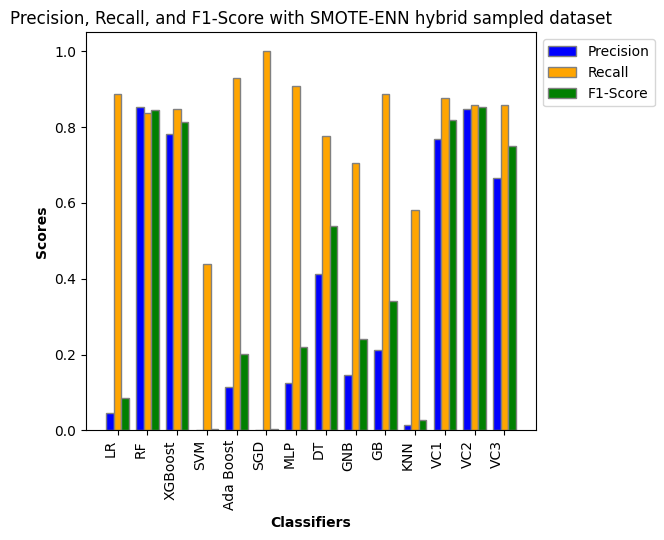

In [14]:
classifiers = ["LR", "RF", "XGBoost", "SVM", "Ada Boost", "SGD", "MLP", "DT", "GNB", "GB", "KNN", "VC1", "VC2", "VC3"]

precision_values = [0.0452, 0.8542, 0.7830, 0.0014, 0.1135, 0.0017, 0.1255, 0.4130, 0.1459, 0.2112, 0.0140, 0.7679, 0.8485, 0.6667]
recall_values = [0.8878, 0.8367, 0.8469, 0.4388, 0.9286, 1.0000, 0.9082, 0.7755, 0.7041, 0.8878, 0.5816, 0.8776, 0.8571, 0.8571]
f1_score_values = [0.0860, 0.8454, 0.8137, 0.0028, 0.2022, 0.0034, 0.2206, 0.5390, 0.2417, 0.3412, 0.0273, 0.8190, 0.8528, 0.7500]

# Create a bar chart
bar_width = 0.25
index = np.arange(len(classifiers))

fig, ax = plt.subplots(figsize=(6.5, 5.5))

bar1 = ax.bar(index, precision_values, bar_width, label='Precision', edgecolor='grey', color='blue')
bar2 = ax.bar(index + bar_width, recall_values, bar_width, label='Recall', edgecolor='grey', color='orange')
bar3 = ax.bar(index + 2 * bar_width, f1_score_values, bar_width, label='F1-Score', edgecolor='grey', color='green')

ax.set_xlabel('Classifiers', fontweight='bold')
ax.set_ylabel('Scores', fontweight='bold')
ax.set_title('Precision, Recall, and F1-Score with SMOTE-ENN hybrid sampled dataset')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(classifiers, rotation=90, ha="right")
ax.legend(["Precision", "Recall", "F1-Score"], bbox_to_anchor=(1, 1), loc="upper left")

plt.tight_layout()
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


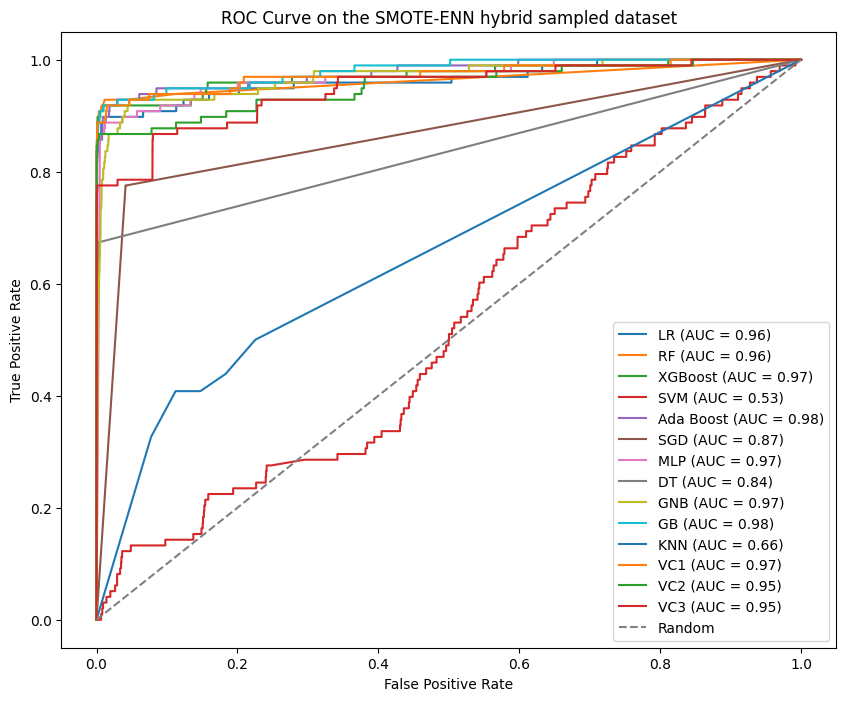

In [15]:
from imblearn.combine import SMOTEENN
classifiers = {
    "LR": LogisticRegression(),
    "RF": RandomForestClassifier(),
    "XGBoost": XGBClassifier(),
    "SVM": SVC(probability=True),
    "Ada Boost": AdaBoostClassifier(),
    "SGD": SGDClassifier(loss='log'),
    "MLP": MLPClassifier(),
    "DT": DecisionTreeClassifier(),
    "GNB": GaussianNB(),
    "GB": GradientBoostingClassifier(),
    "KNN": KNeighborsClassifier(),
    "VC1": VotingClassifier(estimators=[('RF', RandomForestClassifier()), ('XGB', XGBClassifier()), ('MLP', MLPClassifier())], voting='soft'),
    "VC2": VotingClassifier(estimators=[('RF', RandomForestClassifier()), ('XGB', XGBClassifier()), ('KNN', KNeighborsClassifier())], voting='soft'),
    "VC3": VotingClassifier(estimators=[('XGB', XGBClassifier()), ('MLP', MLPClassifier()), ('KNN', KNeighborsClassifier())], voting='soft')
}

# Subsample the dataset
X_train_sub, _, y_train_sub, _ = train_test_split(X_train, y_train, train_size=0.3, stratify=y_train, random_state=42)

# Apply SMOTE-ENN hybrid sampling
smote_enn = SMOTEENN(random_state=42)
X_resampled, y_resampled = smote_enn.fit_resample(X_train_sub, y_train_sub)

# Plot ROC curves for each classifier
plt.figure(figsize=(10, 8))

for name, clf in classifiers.items():
    clf.fit(X_resampled, y_resampled)
    y_prob = clf.predict_proba(X_test)[:, 1]

    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve on the SMOTE-ENN hybrid sampled dataset')
plt.legend()
plt.show()

# **Friedman Test**

In [16]:
pip install imbalanced-learn

In [17]:
from scipy.stats import friedmanchisquare
import numpy as np

xgboost_metrics = {'Accuracy': 0.9993, 'Precision': 0.7830, 'F1-Score': 0.8137, 'Recall': 0.8469, 'ROC AUC': 0.9847, 'FNR': 0.1531, 'FPR': 0.0004}
vc1_metrics = {'Accuracy': 0.9993, 'Precision': 0.7679, 'F1-Score': 0.8190, 'Recall': 0.8776, 'ROC AUC': 0.9862, 'FNR': 0.1224, 'FPR': 0.0005}
vc2_metrics = {'Accuracy': 0.9995, 'Precision': 0.8485, 'F1-Score': 0.8528, 'Recall': 0.8571, 'ROC AUC': 0.9770, 'FNR': 0.1429, 'FPR': 0.0003}
vc3_metrics = {'Accuracy': 0.9990, 'Precision': 0.6667, 'F1-Score': 0.7500, 'Recall': 0.8571, 'ROC AUC': 0.9797, 'FNR': 0.1429, 'FPR': 0.0007}

# Create a matrix of metrics for all classifiers
all_metrics = np.array([list(xgboost_metrics.values()), list(vc1_metrics.values()), list(vc2_metrics.values()), list(vc3_metrics.values())])

# Perform Friedman Test
statistic, p_value = friedmanchisquare(*all_metrics.T)

# Summarize and interpret the result
print("Friedman Test:")
print(f"Chi-squared Statistic: {statistic:.4f}")
print(f"P-Value: {p_value:.4f}")

if p_value <= 0.05:
    print('The difference is statistically significant across at least one metric.')
else:
    print('No statistically significant difference across metrics.')


Friedman Test:
Chi-squared Statistic: 24.0000
P-Value: 0.0005
The difference is statistically significant across at least one metric.
